<a href="https://colab.research.google.com/github/autumn-yng/cnn_fog/blob/main/Tensorflow_CNN_on_fog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow CNN on fog photos
Author: Autumn Nguyen

Independent study Fall 2023 🌟💭

Mentored by Professor Alyx Burns

Mount Holyoke College

\

This notebook has the code I wrote to implement a Convolutional Neural Network (CNN) in Tensorflow to classify fog photos. It also has my explanations of the concepts I learned throughout the process.

The fog photos were taken by the field cameras that Professor Jessica Lundquist, Dr. Steven Pestana (@University of Washington) and I set up on San Juan Island in the summer of 2023, for the purpose of our coastal fog research. I wanted to learn how to efficiently acquire data from these camera photos without having to manually look through the photos to see at what time there had been fog. Aside from my own learning purpose, I hope the CNN I trained can be helpful in supporting coastal fog research 🌫🌊!

## Import libraries and specify path to data

In [ ]:
import tensorflow as tf
import os

import numpy as np
from matplotlib import pyplot as plt

I ran this notebook during T4 GPU, rather than the default CPU, in the runtime type of Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to directory with image files
PATH = "/content/drive/MyDrive/Fog\ FHL\ REU\ 2023/cattlepoint_photos.zip"
!unzip -n -d data $PATH > /dev/null
# If encounter error cannot find file (even when use the correct path with "\" and no typo):
# just disconnect runtime and start again

In [ ]:
import shutil
shutil.rmtree('data/__MACOSX')

## Input pipeline

I used a Keras utility, ```image_dataset_from_directory()```, to read in and pre-process the data. This utility generates a ```tf.data.Dataset```, from image files in the directory we set the path for above. This Dataset allows us to **apply pre-processing** steps (like normalizing pixel values, resizing images, etc.) to the dataset batch by batch.

In simple words, if your dataset has 320 files, this utility will automatically **divide the dataset into 10  batches** of 32 files each, and when you tell it, for example, "give me 70% of all the data you have so that I can train the model", it will **take 32 files, apply the pre-processing steps to those files, give you that batch, then repeat** this 7 times to eventually give you 7 processed batches of images.

Creating the input pipeline this way is essential to this project. I initially loaded all the data into one variable and called the functions to resize and rescale the images on that variable, but Google Colab (the free version) ran out of RAM, crashed, and asked me to upgrade to Colab Pro. Even though I only have 73 image files, each file is originally 2592x1944 pixels, which sums up to **too much memory for Google Colab has to have on RAM at one time**. ```image_dataset_from_directory()``` helps us not need to have all the images on RAM at once -- everytime we need some, it will get a bit of data and pass them through the input pileline, which requires much less RAM.




In [ ]:
data = tf.keras.utils.image_dataset_from_directory('data',
                                                   class_names = ["no_fog", "fog"],
                                                   batch_size=16,
                                                   image_size=(256,256),
                                                   shuffle=True)

Found 73 files belonging to 2 classes.


In [ ]:
''' Add scaling to the data pipeline: scaling the range of each pixel from 0-255 to 0-1 '''
scaled_data = data.map(lambda x,y: (x/255, y))

### Visualize data in a batch

In [ ]:
data_iterator = scaled_data.as_numpy_iterator()

In [ ]:
# try getting one batch
batch = data_iterator.next()

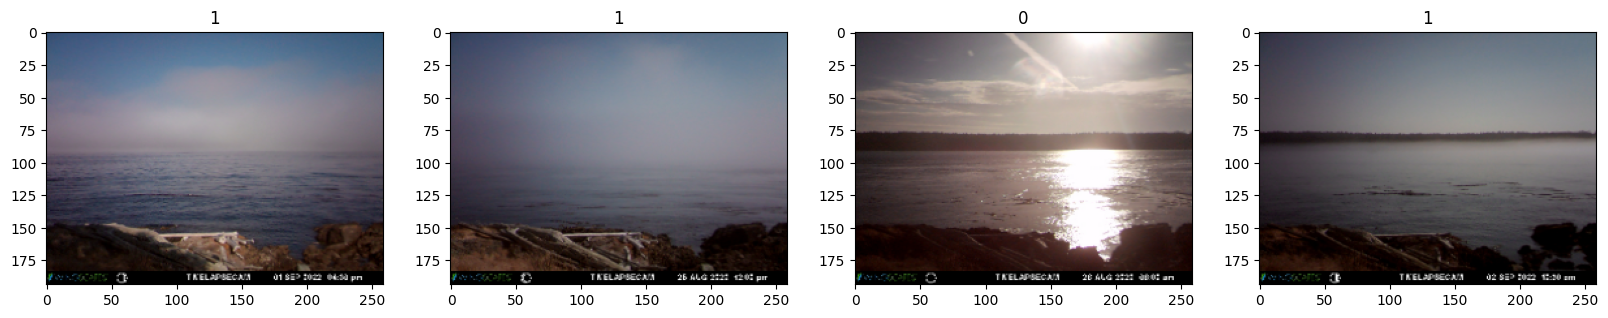

In [ ]:
# visualize the first 4 photos in the generated batch
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(tf.image.resize(img, (1944//10, 2592//10)).numpy()) # If not scaled from 0-255 to 0-1 yet, use .imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Class 0 is images without fog, class 1 is with fog.

## Partition data into train/val/test set

In [ ]:
''' Specify the size of the train/validation/test sets'''

train_size = int(len(scaled_data)*.7)
val_size = int(len(scaled_data)*.2)
test_size = int(len(scaled_data)*.1) + 1

# Make sure train_size, val_size, and test_size sums up to the total number of batches from the whole dataset
print(train_size, val_size, test_size, len(scaled_data))

3 1 1 5


In [ ]:
''' Partition train/val/test '''

# Should make sure the data has already been shuffled (I've done it in image_dataset_from_directory())

train = scaled_data.take(train_size)                          # Take the first 5 batches among the total 8 batches to be the training set
val = scaled_data.skip(train_size).take(val_size)             # Skip the first 5 and take the next 2 batches for validation set.
test = scaled_data.skip(train_size+val_size).take(test_size)  # Skip the batches already taken for train & validation, and take the next 2 batches for the test set.

### Save data in variables (don't run)
This is the old code I used to experiment with saving data from the batches.

In [ ]:
train_batches = train.as_numpy_iterator()
val_batches = val.as_numpy_iterator()
test_batches = test.as_numpy_iterator()

# Store data generated from these batches in variables
# to be able to re-run some functions on them later
# as we cannot get the same batches again after we've depleted data in the data iterator

X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

In [ ]:
# took a long time (~30 secs) just to run: for batch in [1 batch]: X,y = batch
# 2 mins to run when batch_size = 32

for batch in train_batches:
  X_i,y_i = batch
  X_train.append(X_i)
  y_train.append(y_i)

for batch in val_batches:
  X_i,y_i = batch
  X_val.append(X_i)
  y_val.append(y_i)

for batch in test_batches:
  X_i,y_i = batch # these are NumPy arrays. X_i.shape = (32, 400, 600, 3); y_i.shape = (32,0)
  X_test.extend(X_i)
  y_test.extend(y_i)

In [ ]:
X_train = np.array(X_train)
print(X_train.shape)
y_train = np.array(y_train)
print(y_train.shape)

(8, 32, 400, 600, 3)
(8, 32)


In [ ]:
X_train_reshaped = X_train.reshape(8*32, 400, 600, 3)
print(X_train_reshaped.shape)

(256, 400, 600, 3)


In [ ]:
y_train_reshaped = y_train.reshape(8*32)
print(y_train_reshaped.shape)

(256,)


## Model with Convolutional and Pooling layers

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [ ]:
# Design the model architecture
cnn_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (5,5), activation='relu',
                         kernel_initializer='he_normal',
                         input_shape=(256, 256, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model
cnn_1.compile(optimizer = 'adam',
              loss = tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Create a log directory to keep log of the model performance during training, which we can visualize afterwards
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = cnn_1.fit(train,
          validation_data = val,
          epochs = 10,
          callbacks = [tensorboard_callback]
          )

Epoch 1/10
3/3 [==============================] - 7s 1s/step - loss: 1.2591 - accuracy: 0.6667 - val_loss: 1.1425 - val_accuracy: 0.3750
Epoch 2/10
3/3 [==============================] - 6s 2s/step - loss: 0.8684 - accuracy: 0.5833 - val_loss: 0.7352 - val_accuracy: 0.5625
Epoch 3/10
3/3 [==============================] - 4s 905ms/step - loss: 0.5990 - accuracy: 0.7083 - val_loss: 0.4535 - val_accuracy: 0.8125
Epoch 4/10
3/3 [==============================] - 4s 914ms/step - loss: 0.5708 - accuracy: 0.6458 - val_loss: 0.4407 - val_accuracy: 0.7500
Epoch 5/10
3/3 [==============================] - 8s 3s/step - loss: 0.4069 - accuracy: 0.8542 - val_loss: 0.3126 - val_accuracy: 0.8750
Epoch 6/10
3/3 [==============================] - 5s 1s/step - loss: 0.4185 - accuracy: 0.7292 - val_loss: 0.4194 - val_accuracy: 0.8125
Epoch 7/10
3/3 [==============================] - 4s 913ms/step - loss: 0.3203 - accuracy: 0.9375 - val_loss: 0.2689 - val_accuracy: 1.0000
Epoch 8/10
3/3 [================

In [ ]:
cnn_1.summary() # need to specify input shape when creating the first Conv2D layer

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 123008)            0         
                                                                 
 dense (Dense)               (None, 1)                 1

## Plot performance

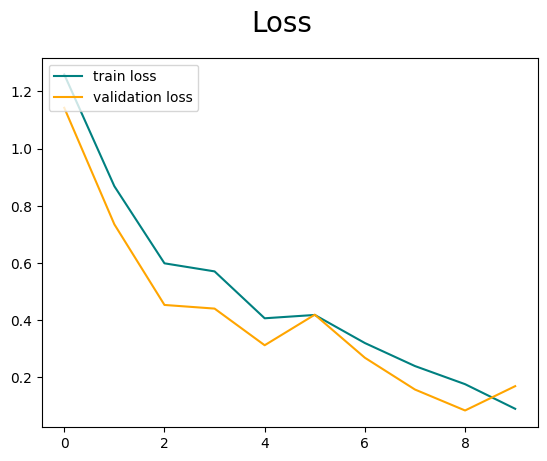

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='train loss')
plt.plot(hist.history['val_loss'], color='orange', label='validation loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

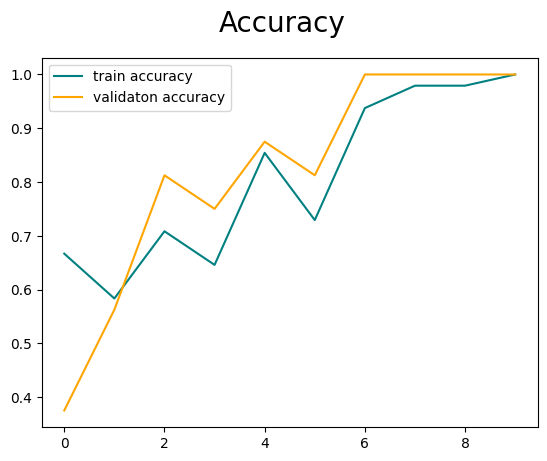

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='train accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='validaton accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluation

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()       # What proportion of fog predictions was actually real fog? (TP/ TP + FP)
re = Recall()           # What proportion of actual fog was corrected identified? (TP / TP + FN)
acc = BinaryAccuracy()  # Just accuracy for binary classificatrion (?)

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = cnn_1.predict(X)

    predicted = []
    predicted = yhat>0.5
    print("True labels: ", y)
    print("Predicted labels: ", predicted.flatten())

    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(pre.result().numpy(), re.result().numpy(), acc.result().numpy())

1/1 [==============================] - 0s 146ms/step
True labels:  [0 0 1 0 1 0 0 0 1]
Predicted labels:  [False False  True False  True False False False  True]
1.0 1.0 1.0


#### If testing on stored variables (don't run)

In [ ]:
# For stored variables (don't run)
# for i in range(len(X_test)):
#     yhat = model.predict(X_test[i])

#     predicted = []
#     predicted = yhat>0.5
#     print("True labels: ", y_test[i])
#     print("Predicted labels: ", predicted.flatten())

#     pre.update_state(y_test[i], yhat)
#     re.update_state(y_test[i], yhat)
#     acc.update_state(y_test[i], yhat)

# print(pre.result().numpy(), re.result().numpy(), acc.result().numpy())

## Test

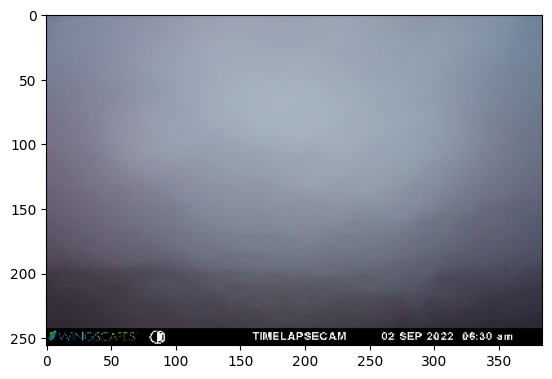

1/1 [==============================] - 0s 80ms/step
[[0.9796394]]
Predicted: Fog


In [ ]:
import cv2

img = cv2.imread("WSCT8724.JPG")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(tf.image.resize(img, (256,384)).numpy().astype(int))
plt.show()

resize = tf.image.resize(img, (256,256))
yhat = cnn_1.predict(np.expand_dims(resize/255, 0))
print(yhat)
if yhat > 0.5:
    print(f'Predicted: Fog')
else:
    print(f'Predicted: No Fog')


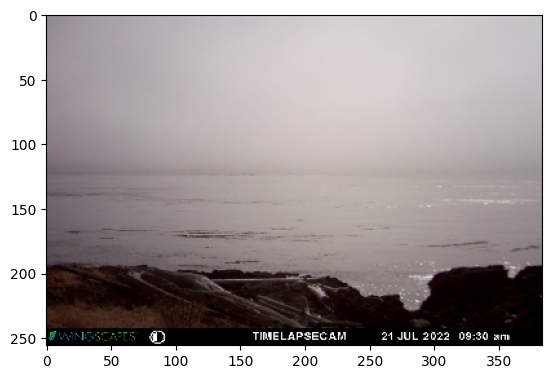

1/1 [==============================] - 0s 63ms/step
[[0.989678]]
Predicted: Fog


In [ ]:
import cv2

img = cv2.imread("WSCT7354.JPG")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(tf.image.resize(img, (256,384)).numpy().astype(int))
plt.show()

resize = tf.image.resize(img, (256,256))
yhat = cnn_1.predict(np.expand_dims(resize/255, 0))
print(yhat)
if yhat > 0.5:
    print(f'Predicted: Fog')
else:
    print(f'Predicted: No Fog')


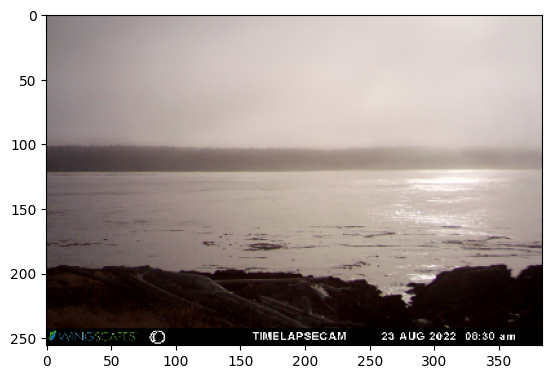

1/1 [==============================] - 0s 31ms/step
[[0.93359524]]
Predicted: Fog


In [ ]:
import cv2

img = cv2.imread("WSCT8408.JPG")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(tf.image.resize(img, (256,384)).numpy().astype(int))
plt.show()

resize = tf.image.resize(img, (256,256))
yhat = cnn_1.predict(np.expand_dims(resize/255, 0))
print(yhat)
if yhat > 0.5:
    print(f'Predicted: Fog')
else:
    print(f'Predicted: No Fog')


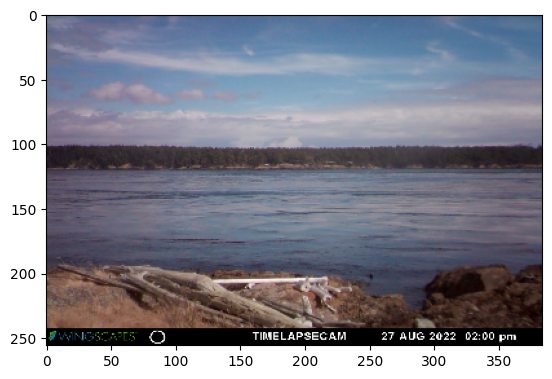

1/1 [==============================] - 0s 29ms/step
[[0.31131524]]
Predicted: No Fog


In [ ]:
import cv2

img = cv2.imread("WSCT8547.JPG")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(tf.image.resize(img, (256,384)).numpy().astype(int))
plt.show()

resize = tf.image.resize(img, (256,256))
yhat = cnn_1.predict(np.expand_dims(resize/255, 0))
print(yhat)
if yhat > 0.5:
    print(f'Predicted: Fog')
else:
    print(f'Predicted: No Fog')


## Save the model

In [ ]:
cnn_1.save('/content/drive/MyDrive/Fog FHL REU 2023/cnn_1.h5')

In [ ]:
# from tensorflow.keras.models import load_model
# cnn_1 = load_model('/content/drive/MyDrive/Computer Science/PlantsPicture/ML models/cnn_1.h5')